In [1]:
from clawpack.pyclaw.solution import Solution
import numpy as np
import matplotlib.pyplot as plt
from clawpack import visclaw
from clawpack.visclaw.ianimate import ianimate
from nodepy import rk
import os, sys
import scipy.io
import scipy.integrate as integrate
from Num_Sol_1D_SWE import setup

In [2]:
def butcher_coeff(s,p,q,sch_no):
# Coefficients of Runge-Kutta method
#------------------------------#
    # Method 1: (3,3,1)
    if s == 3 and p == 3 and q == 1 and sch_no == 1:
        ssp33 = rk.loadRKM('SSP33')
        a = ssp33.A.astype('float64')
        b = ssp33.b.astype('float64')
        c = ssp33.c.astype('float64')
    # Method 2 (5,3,3)
    elif s == 5 and p == 3 and q == 3 and sch_no == 2:
#------------------------------#
        # Method 2: (5,3,3)
        a = np.array([[                  0,                 0,       0,              0,      0],
                      [               4/25,                 0,       0,              0,      0],
                      [       40646/132219,      47500/132219,       0,              0,      0],
                      [    -587499/3134080,     712975/626816,       0,              0,      0],
                      [ -12747373/12002547, 35703750/16635109, -90/731, 128000/3291693,      0]])

        b = np.array([24989/9120, -580625/144096, 103761/25840, -296720/76551, 43/20])
        c = np.sum(a,axis=1)
#------------------------------#
    # Method 3: (4,4,1)
    elif s == 4 and p == 4 and q == 1 and sch_no == 3:        
        rk4 = rk.loadRKM('RK44')
        a = rk4.A.astype('float64')
        b = rk4.b.astype('float64')
        c = rk4.c.astype('float64')
#------------------------------#
    # Method 4: (7,4,4)
    elif s == 7 and p == 4 and q == 4 and sch_no == 4:
        mat = scipy.io.loadmat('ExMthdAs7p4q4.mat') 
        a = np.array(mat['A']);b = np.array(mat['b'][0]);c = np.sum(a,axis=1)
#------------------------------#
    # Method 5: (7,5,1)
    elif s == 7 and p == 5 and q == 1 and sch_no == 5:
        dp5 = rk.loadRKM('DP5')
        a = dp5.A.astype('float64')
        b = dp5.b.astype('float64')
        c = dp5.c.astype('float64')
#------------------------------#
    # Method 5: (10,5,5)
    elif s == 10 and p == 5 and q == 5 and sch_no == 6: 
        mat = scipy.io.loadmat('ExMthdAs10p5q5.mat') 
        a = np.array(mat['A']);b = np.array(mat['b'].T)[0];c = np.sum(a,axis=1)
#------------------------------#
    return a,b,c

In [3]:
def fun_h(x,t):
    return (1+x)/(1+t) # manufactured solution such that there is no spatial error 

def fun_u(x,t):
    return (1+x**2)/(0.5+t) # manufactured solution such that there is no spatial error 

# momentum function
def fun_hu(x,t):
    return fun_h(x,t)*fun_u(x,t)

def fun_h_cell_avg(x,t):
    dx = x[1] - x[0]; sol = np.zeros((len(x)))
    for i in range(len(x)):
        I1 = integrate.quad(lambda x: fun_h(x,t), x[i]-dx/2,x[i]+dx/2)
        sol[i] = I1[0]/dx
    return sol

def fun_hu_cell_avg(x,t):
    dx = x[1] - x[0]; sol = np.zeros((len(x)))
    for i in range(len(x)):
        I1 = integrate.quad(lambda x: fun_hu(x,t), x[i]-dx/2,x[i]+dx/2)
        sol[i] = I1[0]/dx
    return sol

def compute_err(N, s, p, q, sch_no, solver_type, tfinal, cfl):
    errs_h = []; errs_hu = [];
    for idx in range(len(N)):
        print(N[idx])
        a,b,c = butcher_coeff(s, p, q, sch_no)
        claw = setup(mx=N[idx],a=a,b=b,c=c,solver_type=solver_type,tfinal=tfinal, cfl = cfl) 
        claw.run()
        frame = claw.frames[-1]; xc = frame.grid.x.centers; t = tfinal
        num_h = frame.q[0]; num_hu = frame.q[1]
        true_h = fun_h_cell_avg(xc,t); true_hu = fun_hu_cell_avg(xc,t); 
        err_h = np.max(np.abs(true_h-num_h)); err_hu = np.max(np.abs(true_hu-num_hu))
        errs_h.append(err_h); errs_hu.append(err_hu)
    return errs_h, errs_hu

## Convergence test

In [4]:
N = np.ceil(5*10**np.linspace(1,2.5,8))[:-1]; 
solver_type='sharpclaw'; tfinal=0.5; cfl = 0.8; dts = cfl*(1./N)/2; 
S = [3,5,4,7,7,10];P =[3,3,4,4,5,5]; Q =[1,3,1,4,1,5]; SCH_NO = [1,2,3,4,5,6]


# uncomment here to rerun the code
Err_u = np.zeros((len(S),len(N))); Err_hu = np.zeros((len(S),len(N)))

for i in range(len(S)):
    print("(Method = (%d,%d,%d))"%(S[i], P[i], Q[i]))
    errs_h, errs_hu = compute_err(N, S[i], P[i], Q[i], SCH_NO[i], solver_type, tfinal, cfl)
    Err_u[i,:] = errs_h; Err_hu[i,:] = errs_hu;

(Method = (3,3,1))
50.0
2023-09-06 12:23:50,131 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-06 12:23:50,161 INFO CLAW: Solution 1 computed for time t=0.050000
2023-09-06 12:23:50,191 INFO CLAW: Solution 2 computed for time t=0.100000
2023-09-06 12:23:50,218 INFO CLAW: Solution 3 computed for time t=0.150000
2023-09-06 12:23:50,243 INFO CLAW: Solution 4 computed for time t=0.200000
2023-09-06 12:23:50,267 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-06 12:23:50,290 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-06 12:23:50,313 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-06 12:23:50,335 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-06 12:23:50,359 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-06 12:23:50,380 INFO CLAW: Solution 10 computed for time t=0.500000
82.0
2023-09-06 12:23:50,400 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-06 12:23:50,467 INFO CLAW: Solution 1 computed for time t=0.05

2023-09-06 12:25:24,145 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-06 12:25:24,308 INFO CLAW: Solution 10 computed for time t=0.500000
220.0
2023-09-06 12:25:24,316 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-06 12:25:24,980 INFO CLAW: Solution 1 computed for time t=0.050000
2023-09-06 12:25:25,597 INFO CLAW: Solution 2 computed for time t=0.100000
2023-09-06 12:25:26,174 INFO CLAW: Solution 3 computed for time t=0.150000
2023-09-06 12:25:26,713 INFO CLAW: Solution 4 computed for time t=0.200000
2023-09-06 12:25:27,224 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-06 12:25:27,712 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-06 12:25:28,189 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-06 12:25:28,638 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-06 12:25:29,081 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-06 12:25:29,504 INFO CLAW: Solution 10 computed for time t=0.500000
360.0
2023-09-06 

2023-09-06 12:28:34,133 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-06 12:28:36,459 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-06 12:28:38,702 INFO CLAW: Solution 10 computed for time t=0.500000
966.0
2023-09-06 12:28:38,739 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-06 12:28:48,425 INFO CLAW: Solution 1 computed for time t=0.050000
2023-09-06 12:28:57,363 INFO CLAW: Solution 2 computed for time t=0.100000
2023-09-06 12:29:05,731 INFO CLAW: Solution 3 computed for time t=0.150000
2023-09-06 12:29:13,676 INFO CLAW: Solution 4 computed for time t=0.200000
2023-09-06 12:29:21,194 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-06 12:29:28,300 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-06 12:29:35,031 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-06 12:29:41,452 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-06 12:29:47,616 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-06 12:29:5

2023-09-06 12:33:25,292 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-06 12:33:25,395 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-06 12:33:25,491 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-06 12:33:25,587 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-06 12:33:25,678 INFO CLAW: Solution 10 computed for time t=0.500000
135.0
2023-09-06 12:33:25,697 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-06 12:33:26,070 INFO CLAW: Solution 1 computed for time t=0.050000
2023-09-06 12:33:26,409 INFO CLAW: Solution 2 computed for time t=0.100000
2023-09-06 12:33:26,738 INFO CLAW: Solution 3 computed for time t=0.150000
2023-09-06 12:33:27,042 INFO CLAW: Solution 4 computed for time t=0.200000
2023-09-06 12:33:27,333 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-06 12:33:27,602 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-06 12:33:27,867 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-06 12:33:2

2023-09-06 12:37:25,707 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-06 12:37:28,232 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-06 12:37:30,653 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-06 12:37:32,949 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-06 12:37:35,155 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-06 12:37:37,286 INFO CLAW: Solution 10 computed for time t=0.500000
590.0
2023-09-06 12:37:37,303 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-06 12:37:46,355 INFO CLAW: Solution 1 computed for time t=0.050000
2023-09-06 12:37:54,727 INFO CLAW: Solution 2 computed for time t=0.100000
2023-09-06 12:38:02,557 INFO CLAW: Solution 3 computed for time t=0.150000
2023-09-06 12:38:09,912 INFO CLAW: Solution 4 computed for time t=0.200000
2023-09-06 12:38:16,849 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-06 12:38:23,477 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-06 12:38:2

#### Saving data

In [5]:
folder_name = "SWE_1D_ConvgData/"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [6]:
#Convergence plot data
np.save("./%s/SWE_1D_dts_CFL_%1.1f_T_%1.1f.npy"%(folder_name,cfl,tfinal),dts)
np.save("./%s/SWE_1D_Err_u_CFL_%1.1f_T_%1.1f.npy"%(folder_name,cfl,tfinal),Err_u)
np.save("./%s/SWE_1D_Err_hu_CFL_%1.1f_T_%1.1f.npy"%(folder_name,cfl,tfinal),Err_hu)

#### Convergence plot

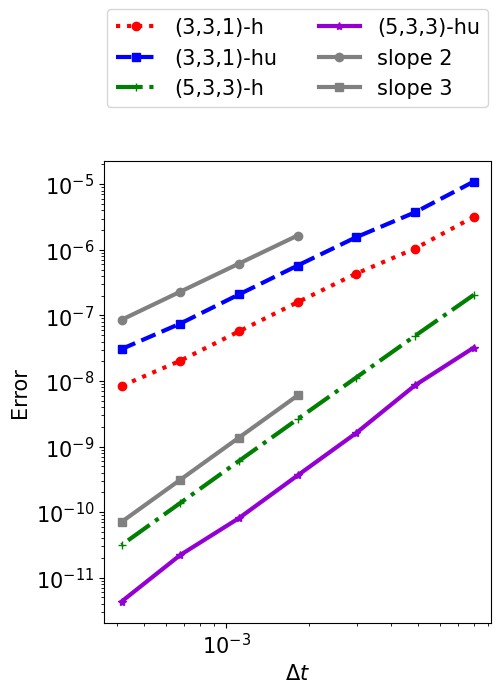

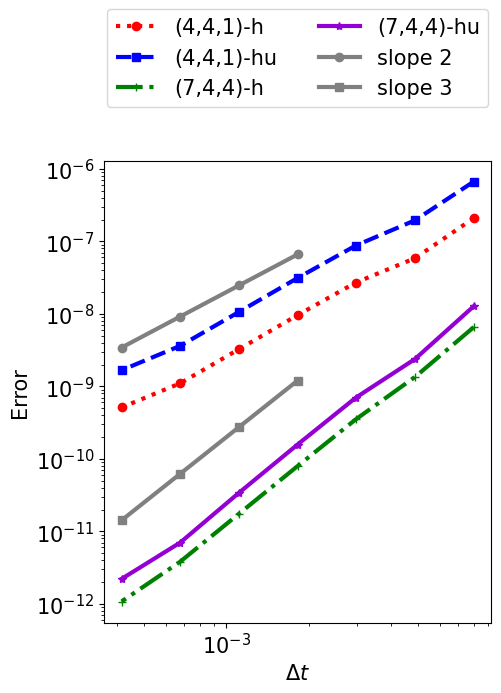

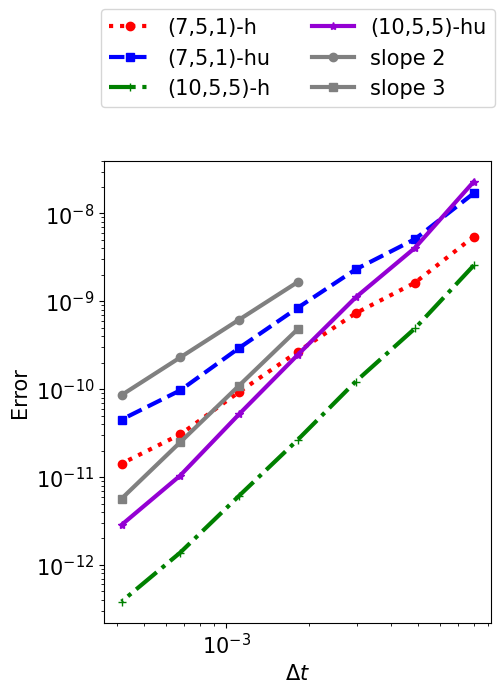

In [7]:


#plotting
dxs = 1./N.T; dts = cfl*dxs/2 
tick_positions = np.linspace(min(dts), max(dts), 3)
custom_ticks = np.linspace(min(dts), max(dts), 3)
Marks = ['o','s','+','*']
lines = [":","--","-.","-"]
colors = ["red", "blue", "green" ,"darkviolet"]

Sl = [2,3,2,3,2,3]; Coeff = [5e-1,1e0,2e-2,2e-1,5e-4,8e-2]; st = 3; en = 7;

font = {#'family' : 'normal',
'weight' : 'normal',
'size'   : 15}
plt.rc('font', **font) 

for i in range(3):
    fig = plt.figure(figsize = (5, 6))
    plt.plot(dts,Err_u[2*i,:],color=colors[0], marker=Marks[0], linestyle=lines[0],linewidth=3, label = "(%d,%d,%d)-h"%(S[2*i],P[2*i],Q[2*i]))
    plt.plot(dts,Err_hu[2*i,:],color=colors[1], marker=Marks[1], linestyle=lines[1],linewidth=3,label = "(%d,%d,%d)-hu"%(S[2*i],P[2*i],Q[2*i]))

    plt.plot(dts,Err_u[2*i+1,:],color=colors[2], marker=Marks[2], linestyle=lines[2],linewidth=3,label = "(%d,%d,%d)-h"%(S[2*i+1],P[2*i+1],Q[2*i+1]))
    plt.plot(dts,Err_hu[2*i+1,:],color=colors[3], marker=Marks[3], linestyle=lines[3],linewidth=3,label = "(%d,%d,%d)-hu"%(S[2*i+1],P[2*i+1],Q[2*i+1]))
    
    plt.plot(dts[st:en],Coeff[2*i]*dts[st:en]**Sl[2*i], "-o", color="gray",linewidth=3,label='slope %d'%(Sl[2*i]))
    plt.plot(dts[st:en], Coeff[2*i+1]*dts[st:en]**Sl[2*i+1], "-s", color="gray",linewidth=3,label='slope %d'%(Sl[2*i+1]))

    plt.xscale("log"); plt.yscale("log"); plt.xlabel('$\Delta t$'); plt.ylabel('Error')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.35),ncol=2)